# Residual Attention Network - 56

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time, os, datetime
import PIL
import pandas as pd
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from tensorflow.keras.datasets import cifar10,cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,TensorBoard, LearningRateScheduler
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input,BatchNormalization,Conv2D,MaxPooling2D,Activation,AveragePooling2D,Flatten,Dropout,Dense

In [3]:
print("TF version: ",tf.__version__)
print("Keras version:",tf.keras.__version__)

TF version:  2.2.0
Keras version: 2.3.0-tf


## Load CIFAR-10 Data

In [4]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [5]:
# normalization
x_train = x_train/255.
x_test  = x_test/255.

In [6]:
# devide into training & validation sets
n_validation = 10000

x_val   = x_train[-n_validation:]
y_val   = y_train[-n_validation:]
x_train = x_train[:-n_validation]
y_train = y_train[:-n_validation]

# Convert to binary class matrix
y_val   = to_categorical(y_val,   num_classes=10)
y_train = to_categorical(y_train, num_classes=10)
y_test  = to_categorical(y_test,  num_classes=10)


print('Training:   ',x_train.shape,y_train.shape)
print('Validation: ',x_val.shape,y_val.shape)
print('Test:       ',x_test.shape,y_test.shape)

Training:    (40000, 32, 32, 3) (40000, 10)
Validation:  (10000, 32, 32, 3) (10000, 10)
Test:        (10000, 32, 32, 3) (10000, 10)


## Data Augmentation

In [7]:
# define generators for training, validation, and test sets
train_datagen = ImageDataGenerator(width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   zoom_range = 0.1,
                                   rotation_range=20,
                                   shear_range = 0.1,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True)


val_datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True)

test_datagen = ImageDataGenerator(featurewise_center=True,
                                  featurewise_std_normalization=True)

# # compute quantities required for feature normalization
# train_datagen.fit(x_train)
# val_datagen.fit(x_val)
# test_datagen.fit(x_test)

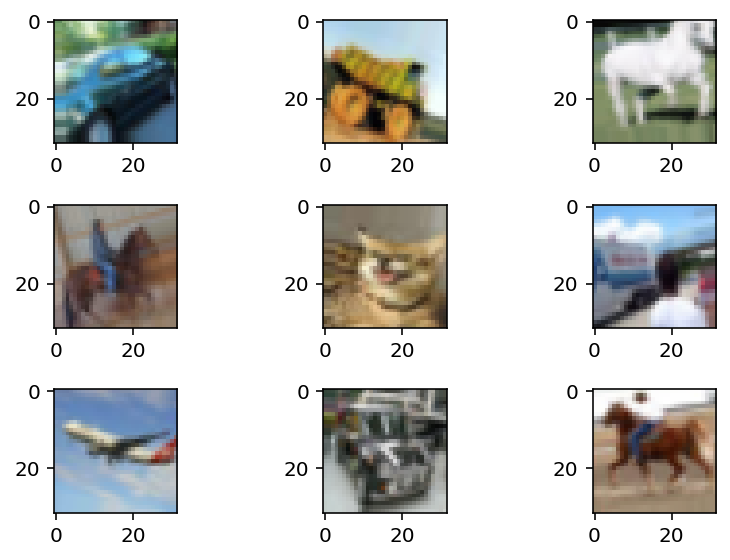

In [10]:
for x_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=9,seed=3019):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i])
    plt.tight_layout()
    break

## Define & Train the model

In [12]:
from utils.models import AttentionResNet56

In [11]:
# define and compile model
model = AttentionResNet56(shape=(32,32,3), in_channel=32, kernel_size=5, n_classes=10, regularization=0.01)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 32)   128         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [13]:
start = time.time()

batch_size = 32
epochs     = 150

# callbacks (Reference: https://github.com/qubvel/residual_attention_network/blob/master/train_cifar10.ipynb)
lr_reducer    = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=7, min_lr=10e-7, epsilon=0.01, verbose=1)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1)


H = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs           = epochs,
                        steps_per_epoch  = len(x_train) // batch_size,
                        validation_data  = val_datagen.flow(x_val, y_val, batch_size=batch_size),
                        callbacks        = [lr_reducer, early_stopper])

end = time.time()
print("Total training time: {}.".format((end-start)/60))


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
1250/1250 [==============================] - 258s 206ms/step - loss: 2.1031 - accuracy: 0.3427 - val_loss: 2.2396 - val_accuracy: 0.3136 - lr: 1.0000e-04
Epoch 2/150
1250/1250 [==============================] - 255s 204ms/step - loss: 1.6853 - accuracy: 0.4469 - val_loss: 1.5160 - val_accuracy: 0.5036 - lr: 1.0000e-04
Epoch 3/150
1250/1250 [==============================] - 256s 205ms/step - loss: 1.5181 - accuracy: 0.4924 - val_loss: 1.4596 - val_accuracy: 0.4961 - lr: 1.0000e-04
Epoch 4/150
1250/1250 [==============================] - 256s 205ms/step - loss: 1.3850 - accuracy: 0.5330 - val_loss: 1.3254 - val_accuracy: 0.5481 - lr: 1.0000e-04
Epoch 5/150
1250/1250 [==============================] - 256s 205ms/step - loss: 1.2789 - accuracy: 0.5627 - val_loss: 1.3072 - val_accuracy: 0.5604 - lr: 1.0000e-04
Epoch 6/150
1250/1250 [==============================] - 256s 205ms/step - loss: 1.1846 - accu

The validation accuracy seems to stop increasing after the 50th Epoch. The performance is similar to https://github.com/qubvel/residual_attention_network/blob/master/train_cifar10.ipynb, but worse than https://github.com/Jay4869/Deep-Learning/blob/2f58356855a170c7a27c955cff9b8ac04b58af79/Training/training_56.ipynb . 

Might need to reschedule the learning rate. lr = 1e-6 might be too small to get the global minimum

## Save model & plot training process

In [14]:
!pwd

/home/ecbm4040/Project


In [15]:
model_name = 'AttentionResNet56_cifar10'
model.save("./Models/"+model_name+".hdf5")

In [36]:
def plot_training(H, model_name):
    acc     = H.history['accuracy']
    val_acc = H.history['val_accuracy']
    loss    = H.history['loss']
    val_loss= H.history['val_loss']

    epochs = range(len(acc))

    fig, axes = plt.subplots(figsize=(10,4),ncols=2)

    axes[0].plot(epochs, acc, 'b',label='Train')
    axes[0].plot(epochs, val_acc, 'r',label='Validation')
    axes[0].set_title('Training and validation accuracy')
    axes[0].legend()


    axes[1].plot(epochs, loss, 'b')
    axes[1].plot(epochs, val_loss, 'r')
    axes[1].set_title('Training and validation loss')
    
    plt.tight_layout()
    plt.rcParams['savefig.dpi'] = 220
    plt.savefig('./Figures/TrainingProcess_'+model_name+'.png')
    
    # save the metrics of training process to a csv file
    hist_df = pd.DataFrame(H.history) 
    hist_df.to_csv('./Models/'+model_name+'_history.csv')

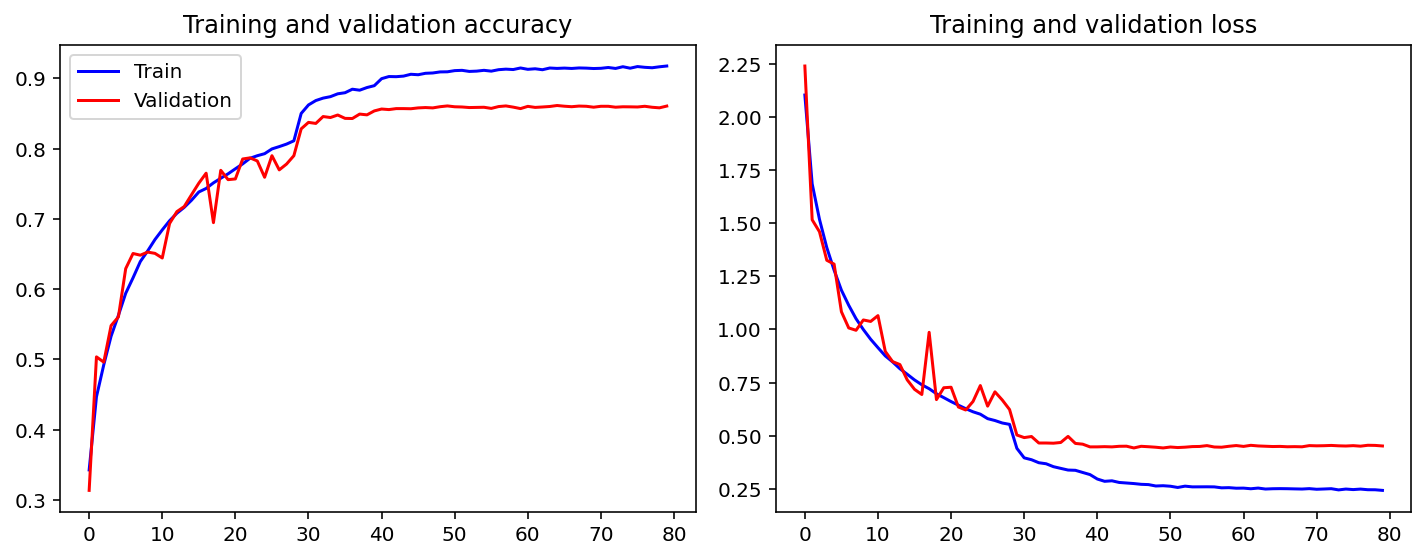

In [37]:
plot_training(H,model_name)

## Evaluation on the test set

In [41]:
test_result = model.evaluate_generator(test_datagen.flow(x_test, y_test), 
                                       steps=len(x_test)/batch_size, 
                                       use_multiprocessing=True)

Instructions for updating:
Please use Model.evaluate, which supports generators.


/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ecbm4040/anaconda3/envs/envTF22/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [42]:
test_result

[0.46864423155784607, 0.8557999730110168]

In [58]:
y_predict = model.predict(x_test)

In [61]:
# compute and plot confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues,save_path=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    fig, axes = plt.subplots(figsize=(12,6),ncols=2)
    
    im = axes[0].imshow(cm, interpolation='nearest', cmap=cmap)
    axes[0].set_title('Confusion matrix without normalization')
    fig.colorbar(im,ax=axes[0],shrink=0.75)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, cm[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm[i, j] > thresh else "black")

    # normalized
    cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_n = np.around(cm_n,decimals=2)

    im_n = axes[1].imshow(cm_n, interpolation='nearest', cmap=cmap)
    axes[1].set_title('Normalized confusion matrix')
    fig.colorbar(im_n,ax=axes[1],shrink=0.75)

    thresh = cm_n.max() / 2.
    for i in range(cm_n.shape[0]):
        for j in range(cm_n.shape[1]):
            axes[1].text(j, i, cm_n[i, j],horizontalalignment="center", fontsize=8,
                         color="white" if cm_n[i, j] > thresh else "black")

    tick_marks = np.arange(len(classes))
    for ax in axes:
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(classes, rotation=45)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes, rotation=45)
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')

    plt.tight_layout()
    
    if save_path is not None:
        plt.rcParams['savefig.dpi'] = 220
        plt.savefig('./Figures/confusion_matrix_'+save_path+'.png')

    
    print('Confusion matrix, without normalization')
    # print(cm)
    print("Normalized confusion matrix")
    # print(cm_n)
    plt.show()

Confusion matrix, without normalization
Normalized confusion matrix


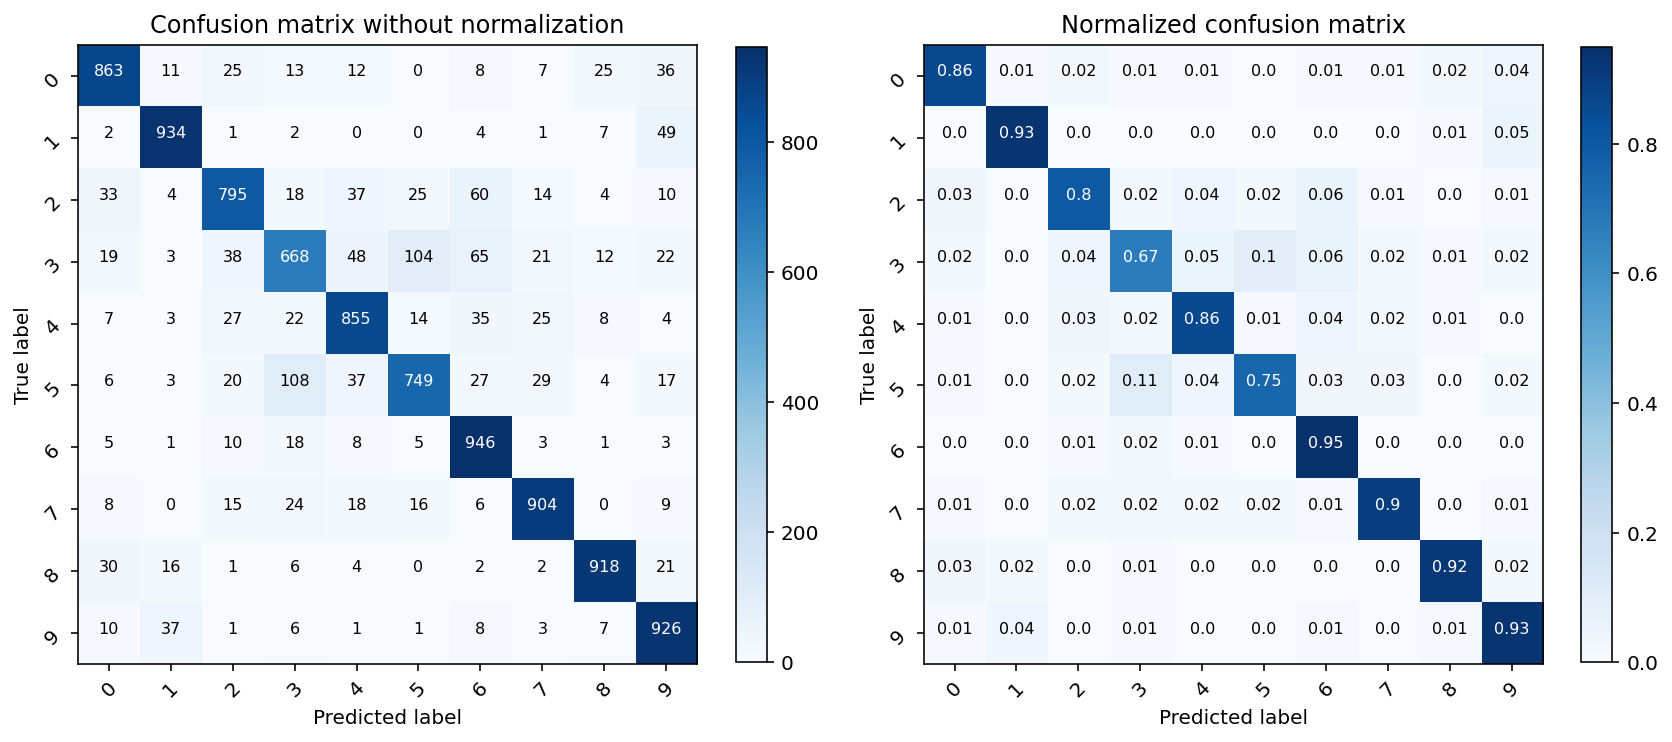

In [64]:
class_labels=['0','1','2','3','4','5','6','7','8','9']

cnf_matrix = confusion_matrix(y_test.argmax(axis=-1),y_predict.argmax(axis=-1)) 
plot_confusion_matrix(cnf_matrix, 
                      classes=class_labels, 
                      cmap=plt.cm.Blues,
                      save_path=model_name)